Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 866ms/step - accuracy: 0.3296 - loss: 14.1650 - val_accuracy: 0.3333 - val_loss: 11.7759 - learning_rate: 1.0000e-04
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 522ms/step - accuracy: 0.3369 - loss: 11.2435 - val_accuracy: 0.3533 - val_loss: 9.3794 - learning_rate: 1.0000e-04
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 553ms/step - accuracy: 0.3259 - loss: 9.0042 - val_accuracy: 0.3967 - val_loss: 7.5207 - learning_rate: 1.0000e-04
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 550ms/step - accuracy: 0.3290 - loss: 7.2400 - val_accuracy: 0.3333 - val_loss: 6.0771 - learning_rate: 1.0000e-04
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 566ms/step - accuracy: 0.3339 - loss: 5.8483 - val_accuracy: 0.3333 - val_loss: 4.9653 - learning_rate: 1.0000e-04
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 557ms/step - accuracy: 0.3364 - loss: 4.7880 - val_accuracy: 0.3967 - val_loss: 4.0764 - learning_rate: 1.0000e-04
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 533ms/step - accuracy: 0

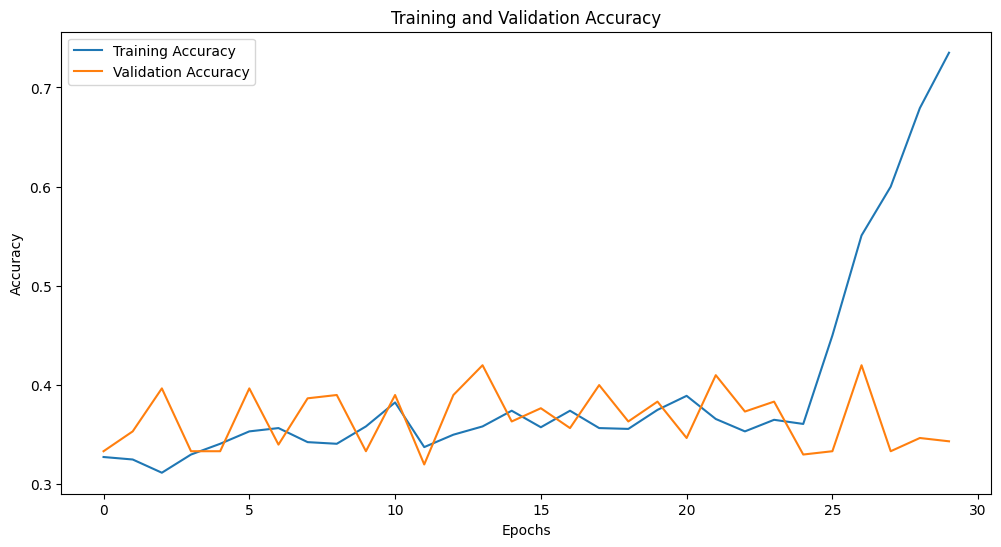

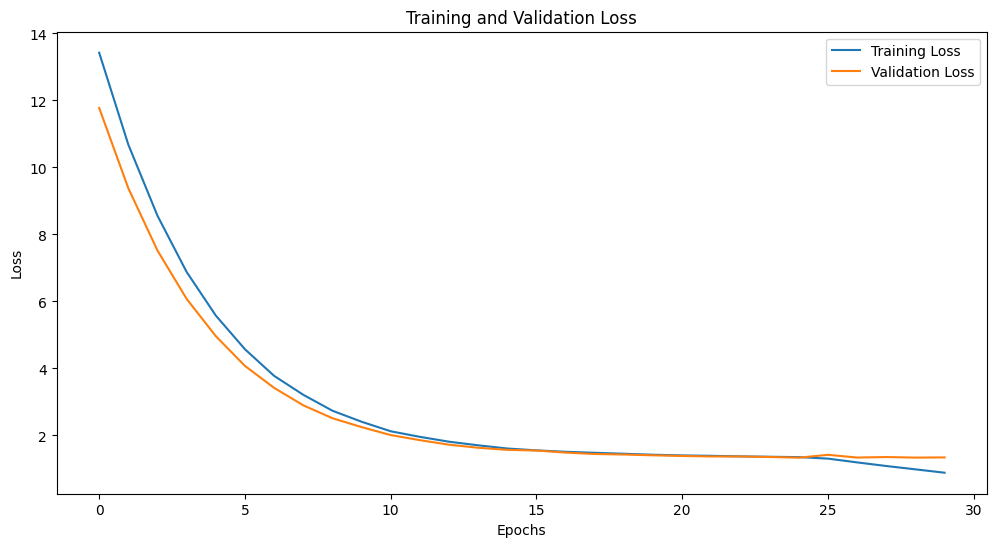

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset directory path
dataset_path = '/content/drive/MyDrive/sinusities/sinusities_dataset'

# Check GPU availability
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Dataset preprocessing with enhanced augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load pre-trained ResNet50 model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers with regularization and dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for Training
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
]

# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

# Fine-tune the model
for layer in base_model.layers:
    layer.trainable = True

# Compile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model for additional epochs
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

# Save the model to Google Drive
model.save('/content/drive/MyDrive/sinusities/resnet_model.h5')

# Visualization of Training and Validation Accuracy and Loss
import matplotlib.pyplot as plt

# Combine histories
history.history['accuracy'] += fine_tune_history.history['accuracy']
history.history['val_accuracy'] += fine_tune_history.history['val_accuracy']
history.history['loss'] += fine_tune_history.history['loss']
history.history['val_loss'] += fine_tune_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()